In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
import sys
from pylab import *
import os
import urllib.request
import seaborn as sns
import random
from adjustText import adjust_text

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

In [2]:
YEAR = 2020
data = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                         'play_by_play_' + str(YEAR) + '.csv.gz?raw=True',
                         compression='gzip', low_memory=False)

In [3]:
#dataGame = data.loc[(data['game_id'] == '2020_01_HOU_KC')]
#dataGame[['play_id', 'posteam', 'wp','def_wp','wpa', 'spread_line']]
#data
pd.options.mode.chained_assignment = None

In [4]:
# keep only plays with an EPA
data = data.loc[
    (data['epa'].notnull()) &
    ((data['play_type'] == 'no_play') |
    (data['play_type'] == 'pass') |
    (data['play_type'] == 'run'))
]

# drop timeouts
data.drop(data[(data['replay_or_challenge'] == 0) & (data['desc'].str.contains('Timeout'))].index, inplace=True)

# drop kneels and spikes
data = data.loc[data.desc.str.contains('kneels|spiked') == False]

# ensure that penalties are not treated as 'no_play'-reassign them to run or pass
# based on their descriptions
data.loc[data.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'),
'play_type'] = 'run'

data.loc[data.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'

In [5]:
#reset index now that data is cleaned up
data.reset_index(drop=True, inplace=True)

In [6]:
#Create a smaller dataframe with plays where rusher_player_name is null
rusher_nan = data.loc[(data['play_type'] == 'run') &
         (data['rusher_player_name'].isnull())]
         
#Create a list of the indexes/indices for the plays where rusher_player_name is null
rusher_nan_indices = list(rusher_nan.index)

for i in rusher_nan_indices:
    #Split the description on the blank spaces, isolating each word
    desc = data['desc'].iloc[i].split()
    #For each word in the play description
    for j in range(0,len(desc)):
        #If a word is right, up, or left
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            #Set rusher_player_name for that play to the word just before the direction
            data['rusher_player_name'].iloc[i] = desc[j-1]     
        else:
            pass
        
#Create a smaller dataframe with plays where passer_player_name is null
passer_nan = data.loc[(data['play_type'] == 'pass') &
         (data['passer_player_name'].isnull())]
#Create a list of the indexes/indices for the plays where passer_player_name is null
passer_nan_indices = list(passer_nan.index)

for i in passer_nan_indices:
    #Split the description on the blank spaces, isolating each word
    desc = data['desc'].iloc[i].split()
    #For each word in the play description
    for j in range(0,len(desc)):
        #If a word is pass
        if desc[j] == 'pass':
            data['passer_player_name'].iloc[i] = desc[j-1]            
        else:
            pass
#Change any backwards passes that incorrectly labeled passer_player_name as Backward
data.loc[data['passer_player_name'] == 'Backward', 'passer_player_name'] == float('NaN')

#do it again for receivers
receiver_nan = data.loc[(data['play_type'] == 'pass') & 
                        (data['receiver_player_name'].isnull()) &
                        (data['desc'].str.contains('scrambles|sacked|incomplete')==False)]

receiver_nan_indices = list(receiver_nan.index)

for i in receiver_nan_indices:
    desc = data['desc'].iloc[i].split()

    for j in range(0,len(desc)):
        if (desc[j]=='left' or desc[j]=='right' or desc[j]=='middle') and (desc[j+1]=='to'):
            data['receiver_player_name'].iloc[i] = desc[j+2]
    else:
        pass

In [14]:
reccpoe = data.groupby('receiver')[['pass_attempt', 'cp', 'cpoe', 'epa', 'air_yards']].sum()
reccpoe['cpoe/p'] = reccpoe.cpoe/reccpoe.pass_attempt
reccpoe['epa/p'] = reccpoe.epa/reccpoe.pass_attempt
reccpoe['airyards/p'] = reccpoe.air_yards/reccpoe.pass_attempt
reccpoe = reccpoe.loc[(reccpoe['pass_attempt'] > 80)]
reccpoe

,pass_attempt,cp,cpoe,epa,air_yards,cpoe/p,epa/p,airyards/p
receiver,,,,,,,,
A.Brown,115.0,71.573625,442.637548,61.718564,1230.0,3.849022,0.536683,10.695652
A.Cooper,112.0,75.237127,476.287258,37.507146,988.0,4.252565,0.334885,8.821429
A.Green,88.0,49.872354,-887.235397,2.312108,1187.0,-10.082220,0.026274,13.488636
A.Kamara,96.0,75.273409,172.659117,8.704952,63.0,1.798532,0.090677,0.656250
A.Robinson,128.0,81.391387,460.861251,26.179015,1238.0,3.600479,0.204524,9.671875
A.Thielen,93.0,54.138854,586.114590,41.300419,1134.0,6.302307,0.444091,12.193548
B.Aiyuk,82.0,52.297446,-229.744583,32.777707,741.0,-2.801763,0.399728,9.036585
B.Cooks,86.0,55.073599,192.640126,27.695969,901.0,2.240001,0.322046,10.476744
C.Beasley,93.0,62.490917,850.908297,53.299369,712.0,9.149552,0.573111,7.655914


In [2]:
#reccpoe.index.values

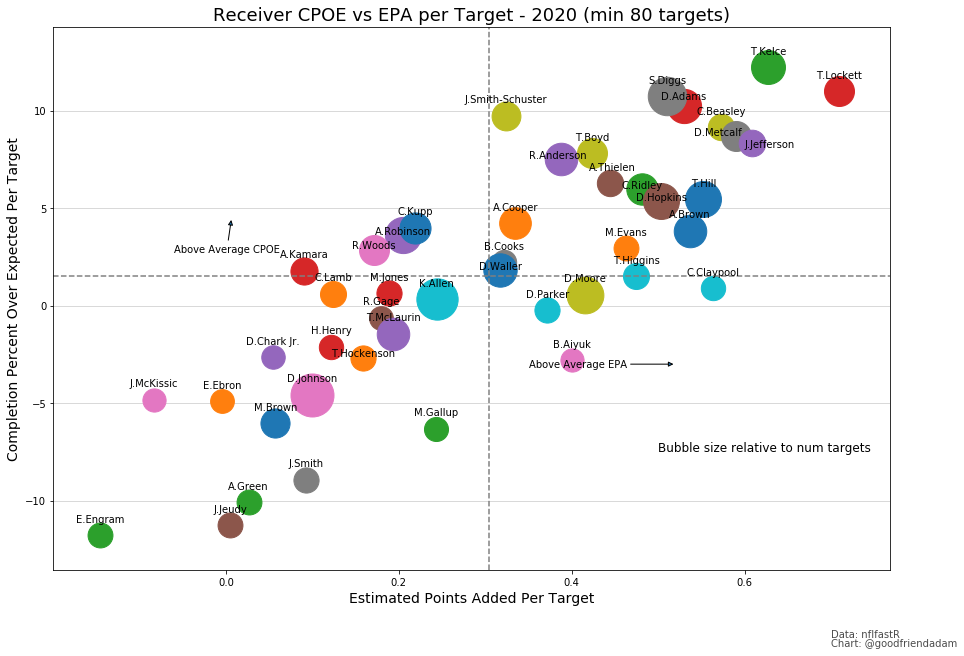

In [15]:
#create figure
fig, ax = plt.subplots(figsize=(15,10))

#make scatter plot with data
#add data to chart
for player, row in reccpoe.iterrows():
    plt.scatter(row['epa/p'], row['cpoe/p'], label=player, s=(row['pass_attempt'])*(row['pass_attempt'])*.08)
    #for diff size dots-> s=(row['pass_attempt'])*(row['pass_attempt'])*.5)
    #plt.text(row['epa/p']-.0235, row['cpoe/p']+.5, player)
    #plt.text(x0, y0, frameon=False, fontsize=4)

#append names and allows to adjust below
texts = []
for x, y, s in zip(reccpoe['epa/p'], reccpoe['cpoe/p'], reccpoe.index.values):
    texts.append(plt.text(x#-.0135
                          , y+.5, s))

#add grid
ax.grid(zorder=0, alpha=.6, axis='y')
ax.set_axisbelow(True)

#set average cpoe
ax.axhline(y=reccpoe['cpoe/p'].mean(), linestyle='--', color='grey')

#set average epa
ax.axvline(x=reccpoe['epa/p'].mean(), linestyle='--', color='grey')

ax.annotate('Above Average CPOE', xy=(.0065, 4.5), xytext=(-0.06, 2.9),
            arrowprops={'arrowstyle': '-|>'}, va='center', color='black', fontsize=10)

#League average line label for epa
ax.annotate('Above Average EPA', xy=(0.52, -3), xytext=(0.35, -3),
            arrowprops={'arrowstyle': '-|>'},  va='center', color='black', fontsize=10)

#add labels and text
ax.set_xlabel('Estimated Points Added Per Target', fontsize=14)
ax.set_ylabel('Completion Percent Over Expected Per Target', fontsize=14)
ax.set_title('Receiver CPOE vs EPA per Target - 2020 (min 80 targets)', fontsize=18)
ax.text(0.5, -7.5, 'Bubble size relative to num targets', fontsize=12, color='black')
ax.text(0.7, -17.5, 'Chart: @goodfriendadam', fontsize=10, alpha=.7)
ax.text(0.7, -17, 'Data: nflfastR', fontsize=10, alpha=.7)
#plt.legend()

#adjust name spacing so no overlaps
adjust_text(texts, autoalign='y',
            only_move={'points':'y', 'text':'xy'})#, arrowprops=dict(arrowstyle='fancy', color='black'))

plt.savefig(os.getcwd() + '\\output\\receivercpoeepa2020.png',dpi=400)

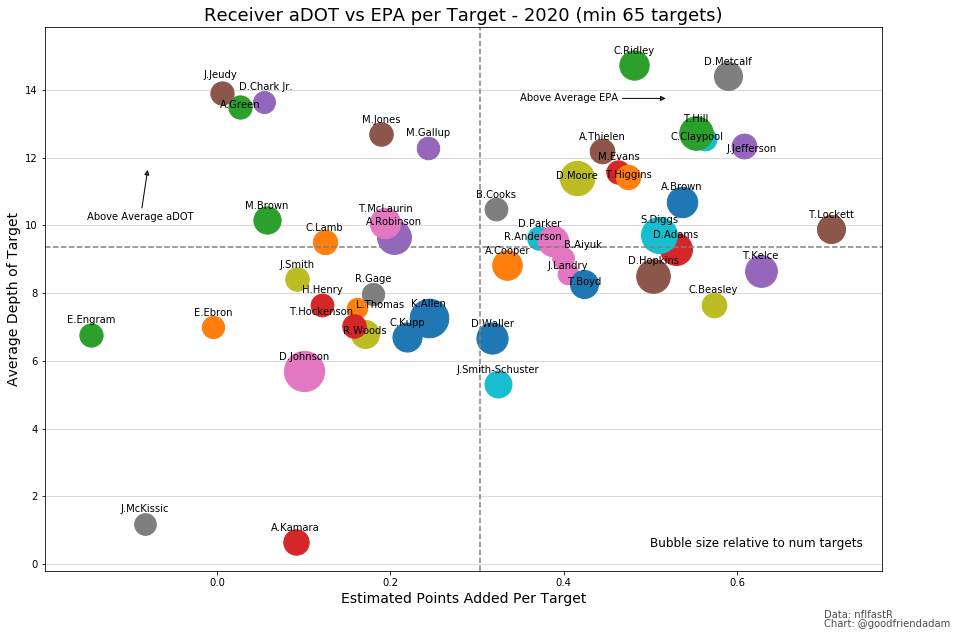

In [10]:
#create figure
fig, ax = plt.subplots(figsize=(15,10))


#make scatter plot with data - alternate?
#x = reccpoe['epa/p']
#y = reccpoe['airyards/p']
#c = sns.color_palette(None, len(reccpoe.index))
#s = (reccpoe['pass_attempt'])*(reccpoe['pass_attempt'])*.08
#scatter = ax.scatter(x, y, c=c, s=s)

#make scatter plot with data
#add data to chart
for player, row in reccpoe.iterrows():
    scatter = plt.scatter(row['epa/p'], row['airyards/p'], label=player, s=(row['pass_attempt'])*(row['pass_attempt'])*.07)
    #for diff size dots-> s=(row['pass_attempt'])*(row['pass_attempt'])*.5)
    #plt.text(row['epa/p']-.0235, row['airyards/p']+.3, player)
    #plt.text(x0, y0, frameon=False, fontsize=4)

#append names and allows to adjust below
texts = []
for x, y, s in zip(reccpoe['epa/p'], reccpoe['airyards/p'], reccpoe.index.values):
    texts.append(plt.text(x#-.018
                          , y+.25, s))

#add grid
ax.grid(zorder=0, alpha=.6, axis='y')
ax.set_axisbelow(True)

#set average cpoe
ax.axhline(y=reccpoe['airyards/p'].mean(), linestyle='--', color='grey')

#set average epa
ax.axvline(x=reccpoe['epa/p'].mean(), linestyle='--', color='grey')

ax.annotate('Above Average aDOT', xy=(-0.08, 11.7), xytext=(-0.15, 10.25),
            arrowprops={'arrowstyle': '-|>'}, va='center', color='black', fontsize=10)

#League average line label for epa
ax.annotate('Above Average EPA', xy=(0.52, 13.75), xytext=(0.35, 13.75),
            arrowprops={'arrowstyle': '-|>'},  va='center', color='black', fontsize=10)

#add labels and text
ax.set_xlabel('Estimated Points Added Per Target', fontsize=14)
ax.set_ylabel('Average Depth of Target', fontsize=14)
ax.set_title('Receiver aDOT vs EPA per Target - 2020 (min 65 targets)', fontsize=18)
ax.text(0.5, 0.5, 'Bubble size relative to num targets', fontsize=12, color='black')
ax.text(0.7, -1.85, 'Chart: @goodfriendadam', fontsize=10, alpha=.7)
ax.text(0.7, -1.6, 'Data: nflfastR', fontsize=10, alpha=.7)
#plt.legend()

#adjust name spacing so no overlaps
adjust_text(texts, autoalign='y',
            only_move={'points':'y', 'text':'xy'})#, arrowprops=dict(arrowstyle='fancy', color='black'))

plt.savefig(os.getcwd() + '\\output\\receiverairyardsepa2020.png',dpi=400)

In [1]:
#cols = data.columns.tolist()
#cols